In [20]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# machine learning
from sklearn.decomposition import PCA

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [21]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-33-52.net.auckland.ac.nz


In [22]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [23]:
# gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# # y-axis processing
# # distance = 3.086e22
# # gw_df = gw_df / distance

# gw_mean = gw_df.mean().mean()
# print('Dataset mean: ',  gw_mean)

# gw_std = gw_df.std().mean()
# print('Dataset std: ',  gw_std)

# gw_scaling_factor = 5
# print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  28.792067898778328
Dataset scaling factor (to match noise in generator):  5


In [24]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        self.parameters = pd.read_csv(parameters_csv)
        # choose only the most important parameters for parameter estimation
        # self.parameters = self.parameters[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']].astype('float32')
        # remove erroneous parameters
        keep_signals_idx = np.array(self.parameters[self.parameters['beta1_IC_b'] > 0].index)
        self.parameters = self.parameters.iloc[keep_signals_idx,:]
        self.parameters['beta1_IC_b_bins'] = pd.qcut(self.parameters['beta1_IC_b'], q=10, labels=False)
        self.parameters = self.parameters[['beta1_IC_b_bins']].astype('float32')

        # convert to numpy array
        self.parameters = self.parameters.values
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        self.data = pd.read_csv(signals_csv).astype('float32')
        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (self.data.shape[0], 0))


    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(10, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]
            # print(signal_after_window)

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            # signal_2 = self.data[:, idx_2]
            # signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]
            augmented_parameter = augmented_parameter.reshape(1, -1)

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print(self.data.shape)
        print(self.parameters.shape)

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # pad signals with edge values to be length 512
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized, parameter

In [25]:
# # for testing
# gw_df = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
# params_df = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")
# params_df = params_df[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']]
# keep_idx = np.array(params_df[params_df['beta1_IC_b'] > 0].index)

# params_df = params_df.iloc[keep_idx,:]
# gw_df = gw_df.iloc[:,keep_idx]

(407, 6000)
(6000, 1)
Dataset mean:  -0.25832042
Dataset std:  32.280373
Dataset scaling factor (to match noise in generator):  5


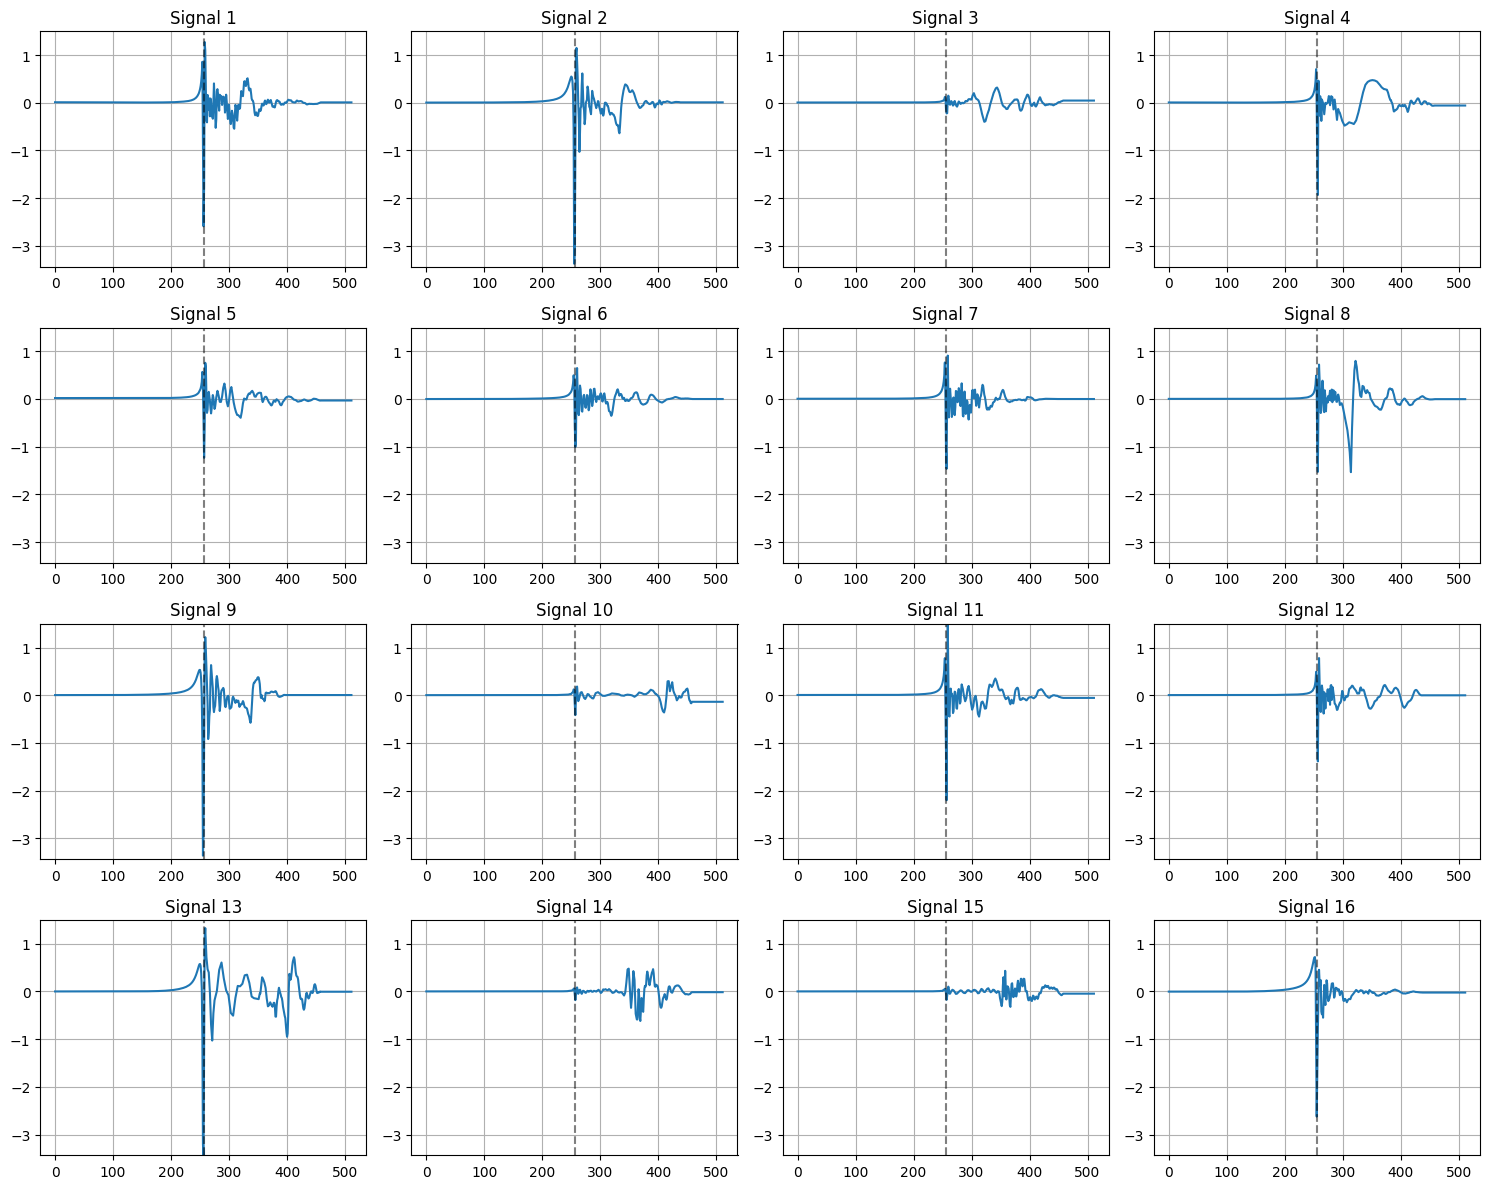

In [26]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")
common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)


        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

In [27]:
dataset.__len__()

6000

### Evaluation Metrics for Data Augmentation

#### KL Distance

In [28]:
num_bins = 100

# Compute histograms of P and Q to represent their probability distributions
# density=True argument ensures that they represent probability distributions (i.e., the integral under each histogram sums to 1).
hist_P, bin_edges_P = np.histogram(dataset.augmented_data, bins=num_bins, density=True)
hist_Q, bin_edges_Q = np.histogram(dataset.original_data, bins=num_bins, density=True)

kl_divergence = entropy(hist_P, hist_Q)
print(kl_divergence)

0.0012036277024127034


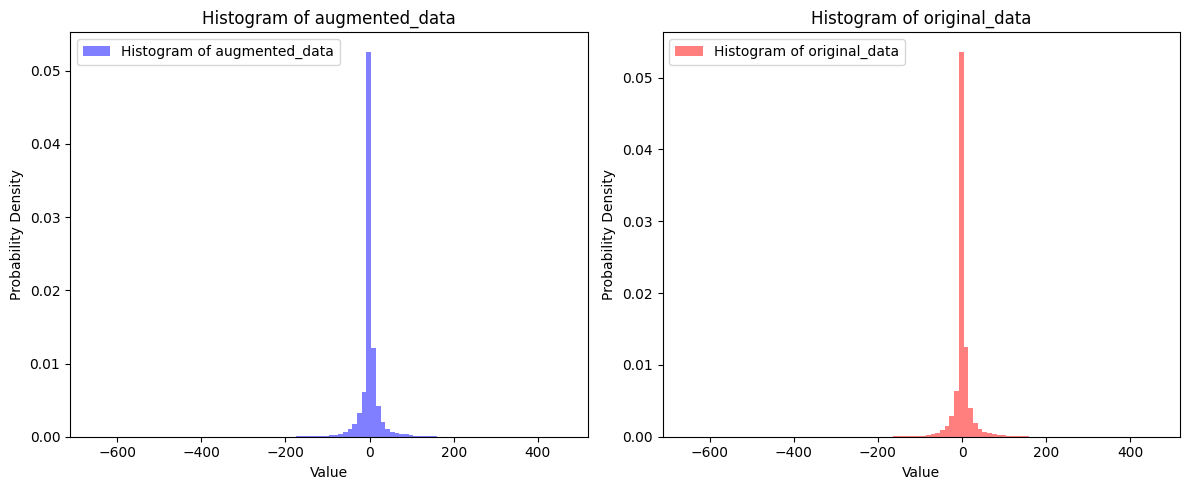

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(bin_edges_P[:-1], bins=bin_edges_P, weights=hist_P, density=True, alpha=0.5, color='blue', label='Histogram of augmented_data')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Histogram of augmented_data')
axes[0].legend(loc='best')

axes[1].hist(bin_edges_Q[:-1], bins=bin_edges_Q, weights=hist_Q, density=True, alpha=0.5, color='red', label='Histogram of original_data')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Histogram of original_data')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

Window warping appears to give quite a low KL distance, meaning that our original and augmented histogram of signal distributions are quite close. Jittering, scaling, and mixture augmentations appear to give infinite KL distances. This coukd be due to mainly altering the amplitude. Shifting gives low KL distances. Inconclusive on whether KL distance is a good metric or it's too sensitive to changes in the amplitude.

NOTE: This comparison is between the original data and ONLY the augmented data. The augmented and original data is combined to create the GAN training dataset.

#### PCA

In [30]:
# Assuming you have two datasets: dataset1 and dataset2
# Perform PCA on both datasets
pca = PCA(n_components=2)  # Choose the number of components
dataset1_pca = pca.fit_transform(dataset.original_data)
# dataset2_pca = pca.transform(dataset.augmented_data)
dataset2_pca = pca.fit_transform(dataset.data)

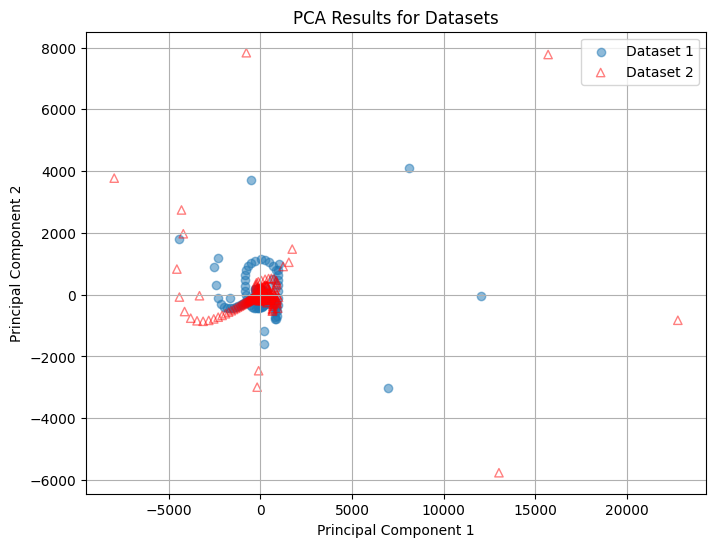

In [31]:

# Scatter plot for dataset1_pca with filled markers
plt.figure(figsize=(8, 6))
plt.scatter(dataset1_pca[:, 0], dataset1_pca[:, 1], label='Dataset 1', alpha=0.5, marker='o')  # 'o' represents filled circles

# Scatter plot for dataset2_pca with hollow markers
plt.scatter(dataset2_pca[:, 0], dataset2_pca[:, 1], label='Dataset 2', alpha=0.5, marker='^', facecolors='none', edgecolors='r')  # '^' represents unfilled triangles

plt.title('PCA Results for Datasets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

They look kinda similar??? Uh not sure what to say.

### Weight Initialisation (Random Noise)

In [32]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [33]:
if (gans_type == 'cdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                # presuming that 10 is the number of class labels?
                nn.ConvTranspose1d(10, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )

            self.main = nn.Sequential(
                nn.ConvTranspose1d(ngf * 126, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = self.z_reshape(z)
            y = self.y_reshape(y)
            z = torch.cat([z, y], 1)
            z = self.main(z)
            return z

elif (gans_type == 'dcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z

In [34]:
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

if (gans_type == 'cdcgans'):
    model = Generator()
    summary(netG, input_size=[(nz, 1), (1, 1)])
elif (gans_type == 'dcgans'):
    model = Generator()
    summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [35]:
if (gans_type == "cdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()

            self.x_reshape = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.y_reshape = nn.Sequential(
                nn.Embedding(10, 50),
                nn.Conv1d(10, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.main = nn.Sequential(
                # nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            x = self.x_reshape(x)
            print(x.shape)
            y = self.y_reshape(y)
            x = torch.cat([x, y], 1)
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

In [36]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

if (gans_type == "cdcgans"):
    model = Discriminator()
    summary(model, input_size=[(1, 512), (1, 1)])
elif (gans_type == "dcgans"):
    model = Discriminator()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.2, inplace

### Loss functions and Optimisers

In [37]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=30)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=30)

### Training

Starting Training Loop...
[0/20][0/188]	Loss_D: 2.4629	Loss_G: 0.5777	D(x): 0.3831	D(G(z)): 0.2884 / 0.3329
[0/20][50/188]	Loss_D: 0.7324	Loss_G: 2.8799	D(x): 0.1602	D(G(z)): 0.7992 / 0.8052
[0/20][100/188]	Loss_D: 0.8944	Loss_G: 2.2575	D(x): 0.1145	D(G(z)): 0.7724 / 0.7626
[0/20][150/188]	Loss_D: 0.8283	Loss_G: 2.9985	D(x): 0.1367	D(G(z)): 0.7843 / 0.8273
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000400 -> 0.0000393


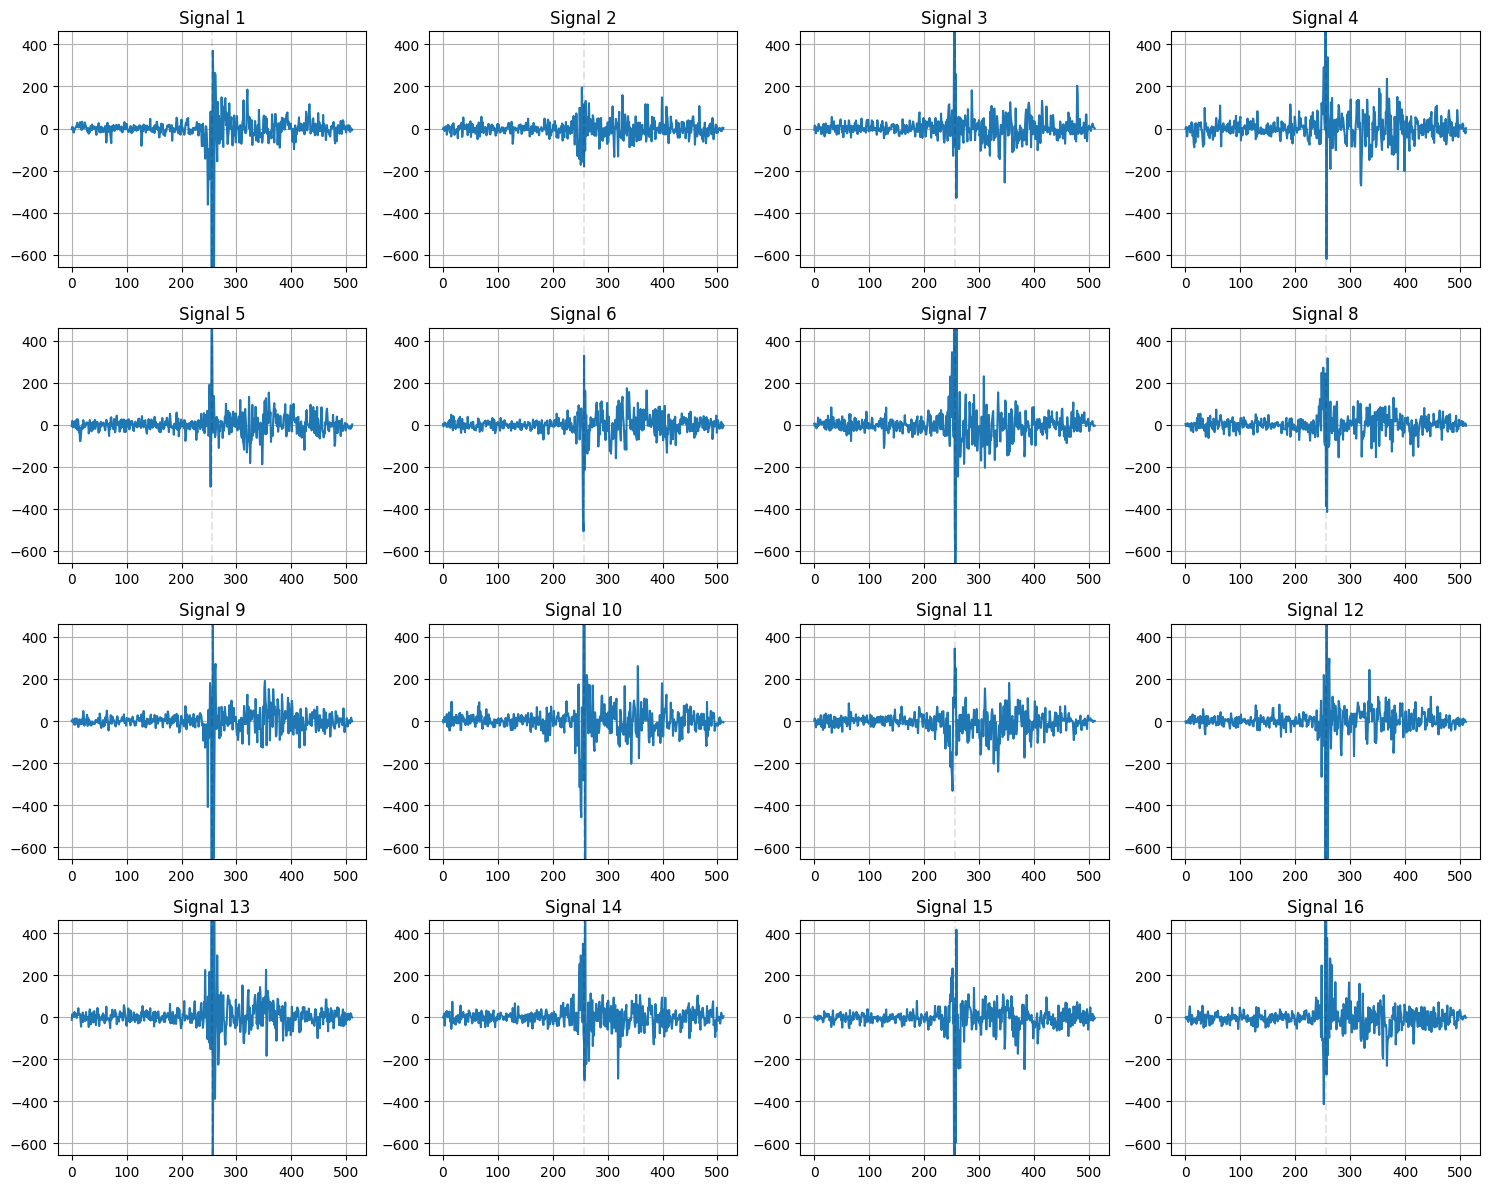

[1/20][0/188]	Loss_D: 0.7953	Loss_G: 2.8633	D(x): 0.0862	D(G(z)): 0.7674 / 0.7897
[1/20][50/188]	Loss_D: 0.8796	Loss_G: 3.3829	D(x): 0.1961	D(G(z)): 0.8226 / 0.8256
[1/20][100/188]	Loss_D: 0.7350	Loss_G: 2.5501	D(x): 0.0755	D(G(z)): 0.7234 / 0.7755
[1/20][150/188]	Loss_D: 1.0703	Loss_G: 4.6278	D(x): 0.1247	D(G(z)): 0.8866 / 0.9113
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000193
Epoch 1: SGD Generator lr 0.0000393 -> 0.0000387


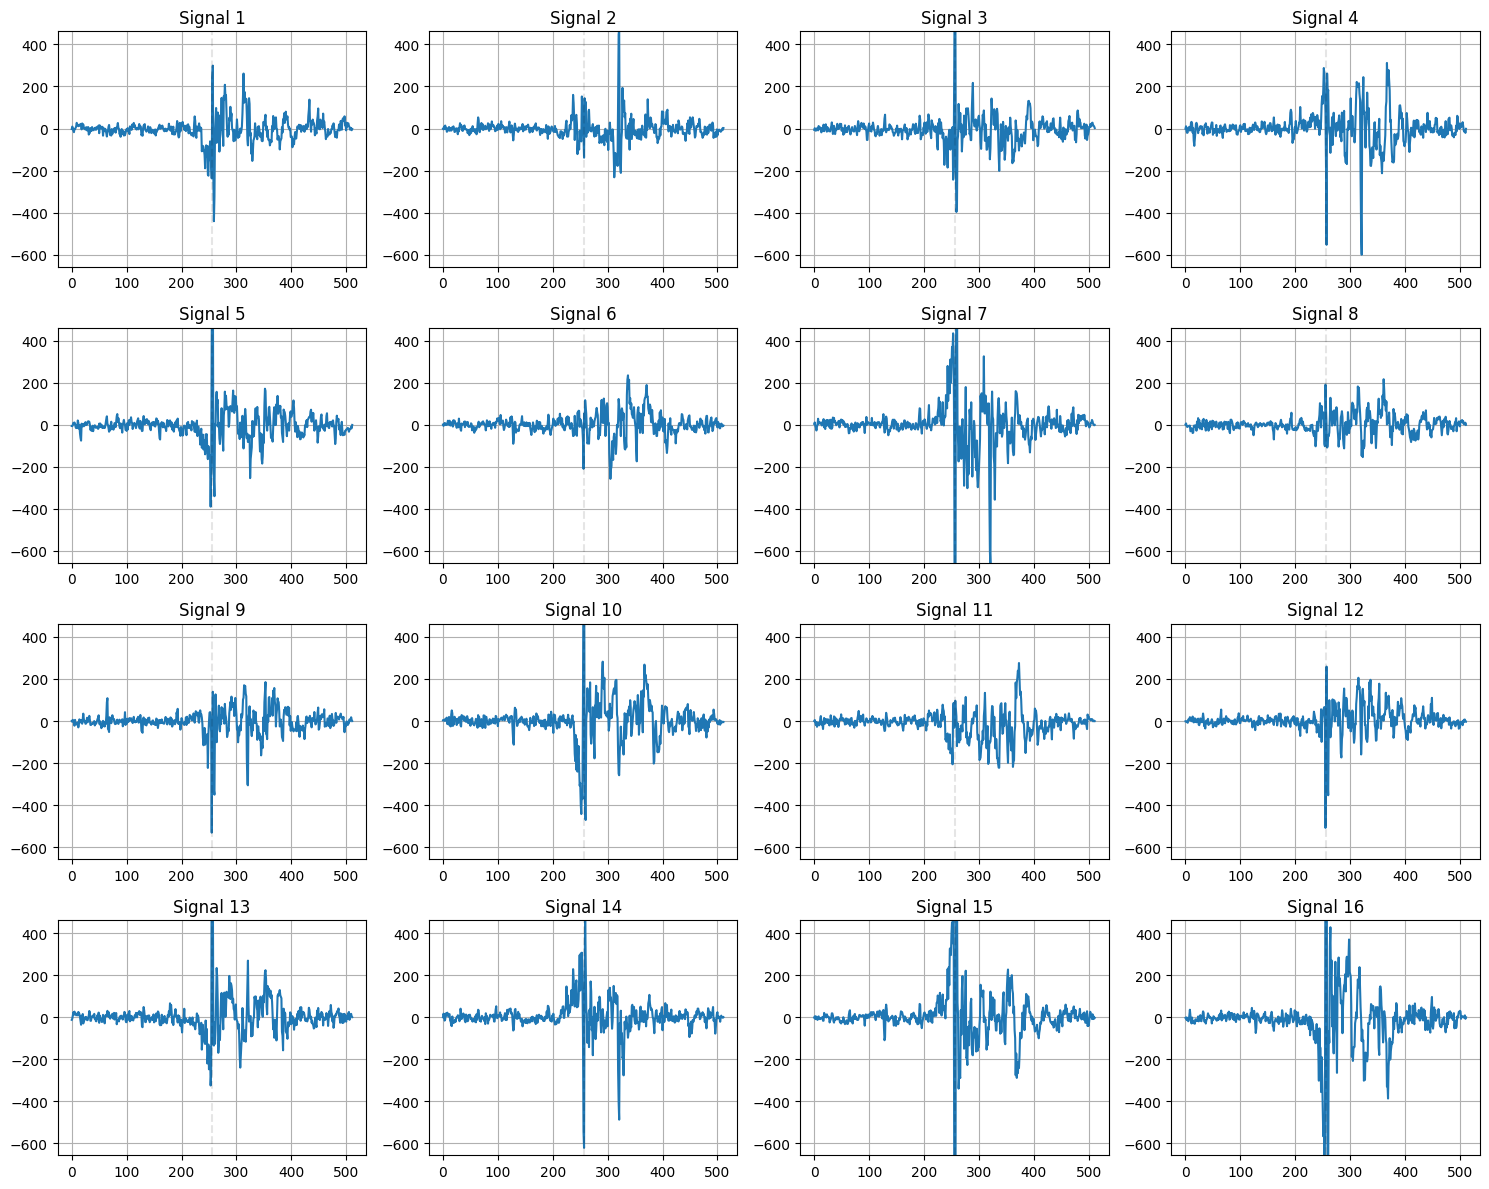

[2/20][0/188]	Loss_D: 0.7240	Loss_G: 2.4827	D(x): 0.1054	D(G(z)): 0.7740 / 0.7901
[2/20][50/188]	Loss_D: 0.7598	Loss_G: 2.6222	D(x): 0.0879	D(G(z)): 0.6590 / 0.8065
[2/20][100/188]	Loss_D: 0.7932	Loss_G: 2.1111	D(x): 0.1452	D(G(z)): 0.7577 / 0.7291
[2/20][150/188]	Loss_D: 0.6949	Loss_G: 1.5778	D(x): 0.1132	D(G(z)): 0.7593 / 0.6699
Epoch 2: SGD Discriminator lr 0.0000193 -> 0.0000190
Epoch 2: SGD Generator lr 0.0000387 -> 0.0000380


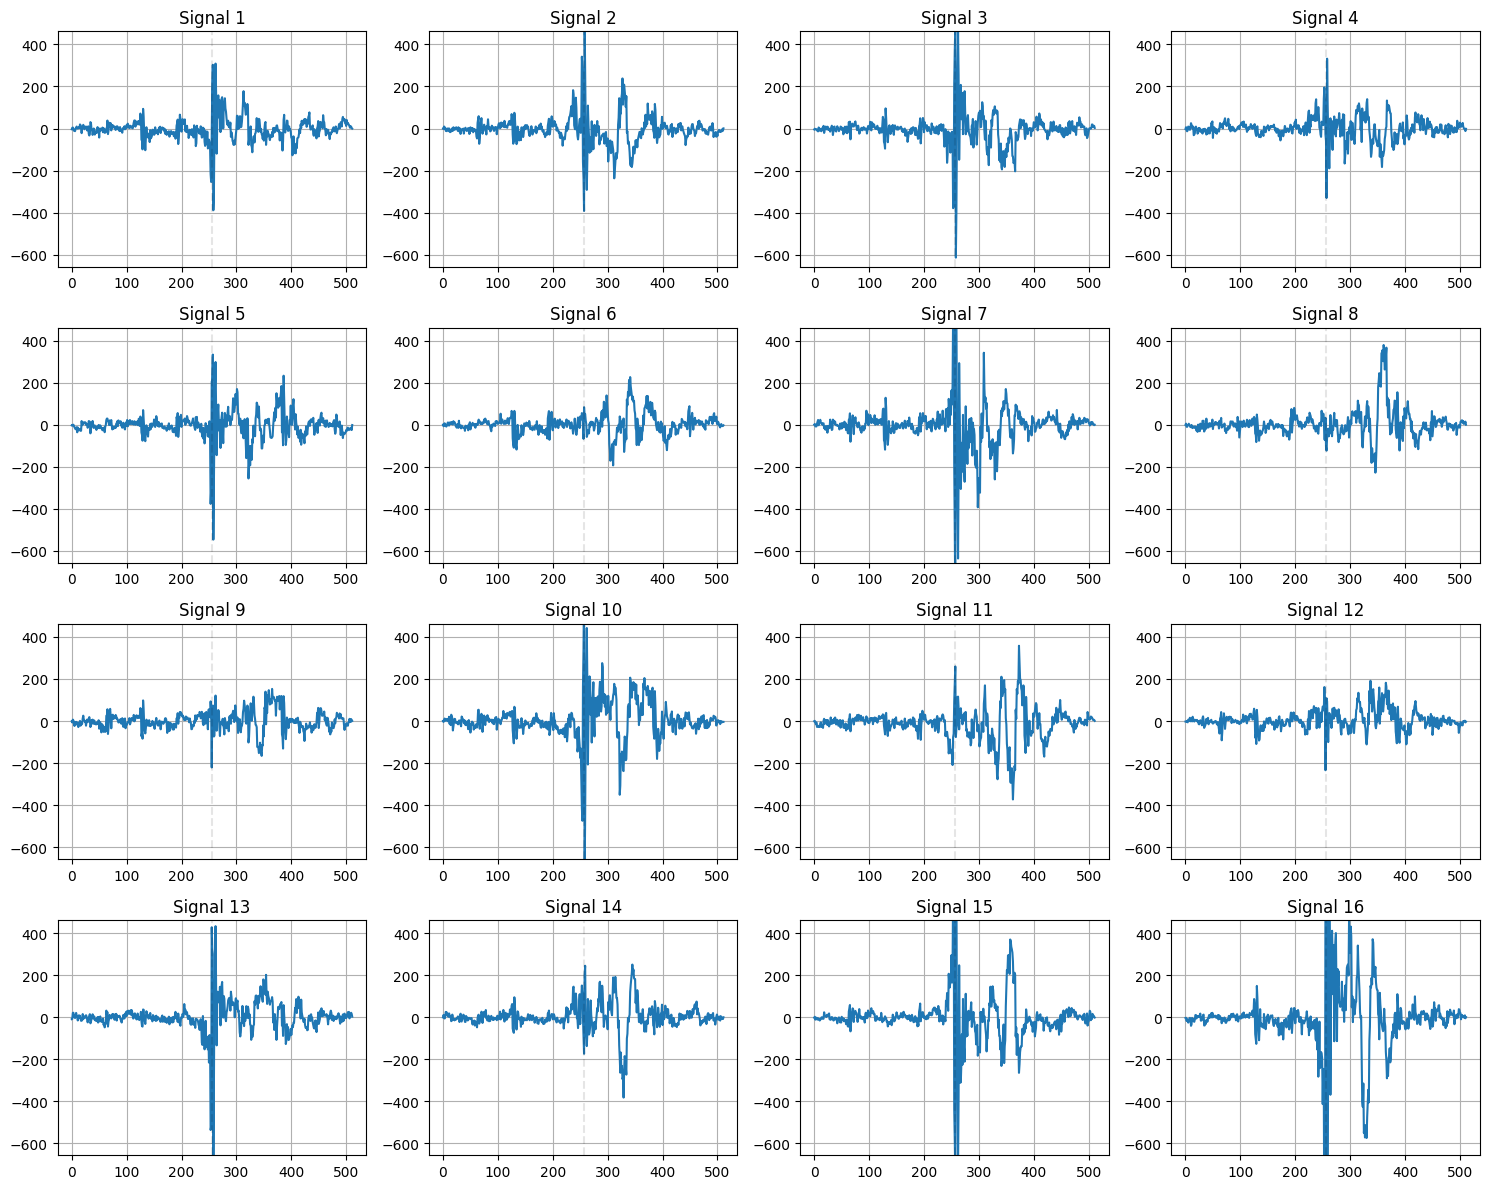

[3/20][0/188]	Loss_D: 0.7717	Loss_G: 3.1480	D(x): 0.1162	D(G(z)): 0.8403 / 0.8316
[3/20][50/188]	Loss_D: 0.8174	Loss_G: 1.6229	D(x): 0.1578	D(G(z)): 0.7051 / 0.6930
[3/20][100/188]	Loss_D: 0.7564	Loss_G: 2.7636	D(x): 0.0998	D(G(z)): 0.7158 / 0.8566
[3/20][150/188]	Loss_D: 0.8114	Loss_G: 2.3577	D(x): 0.1448	D(G(z)): 0.8102 / 0.8017
Epoch 3: SGD Discriminator lr 0.0000190 -> 0.0000187
Epoch 3: SGD Generator lr 0.0000380 -> 0.0000373


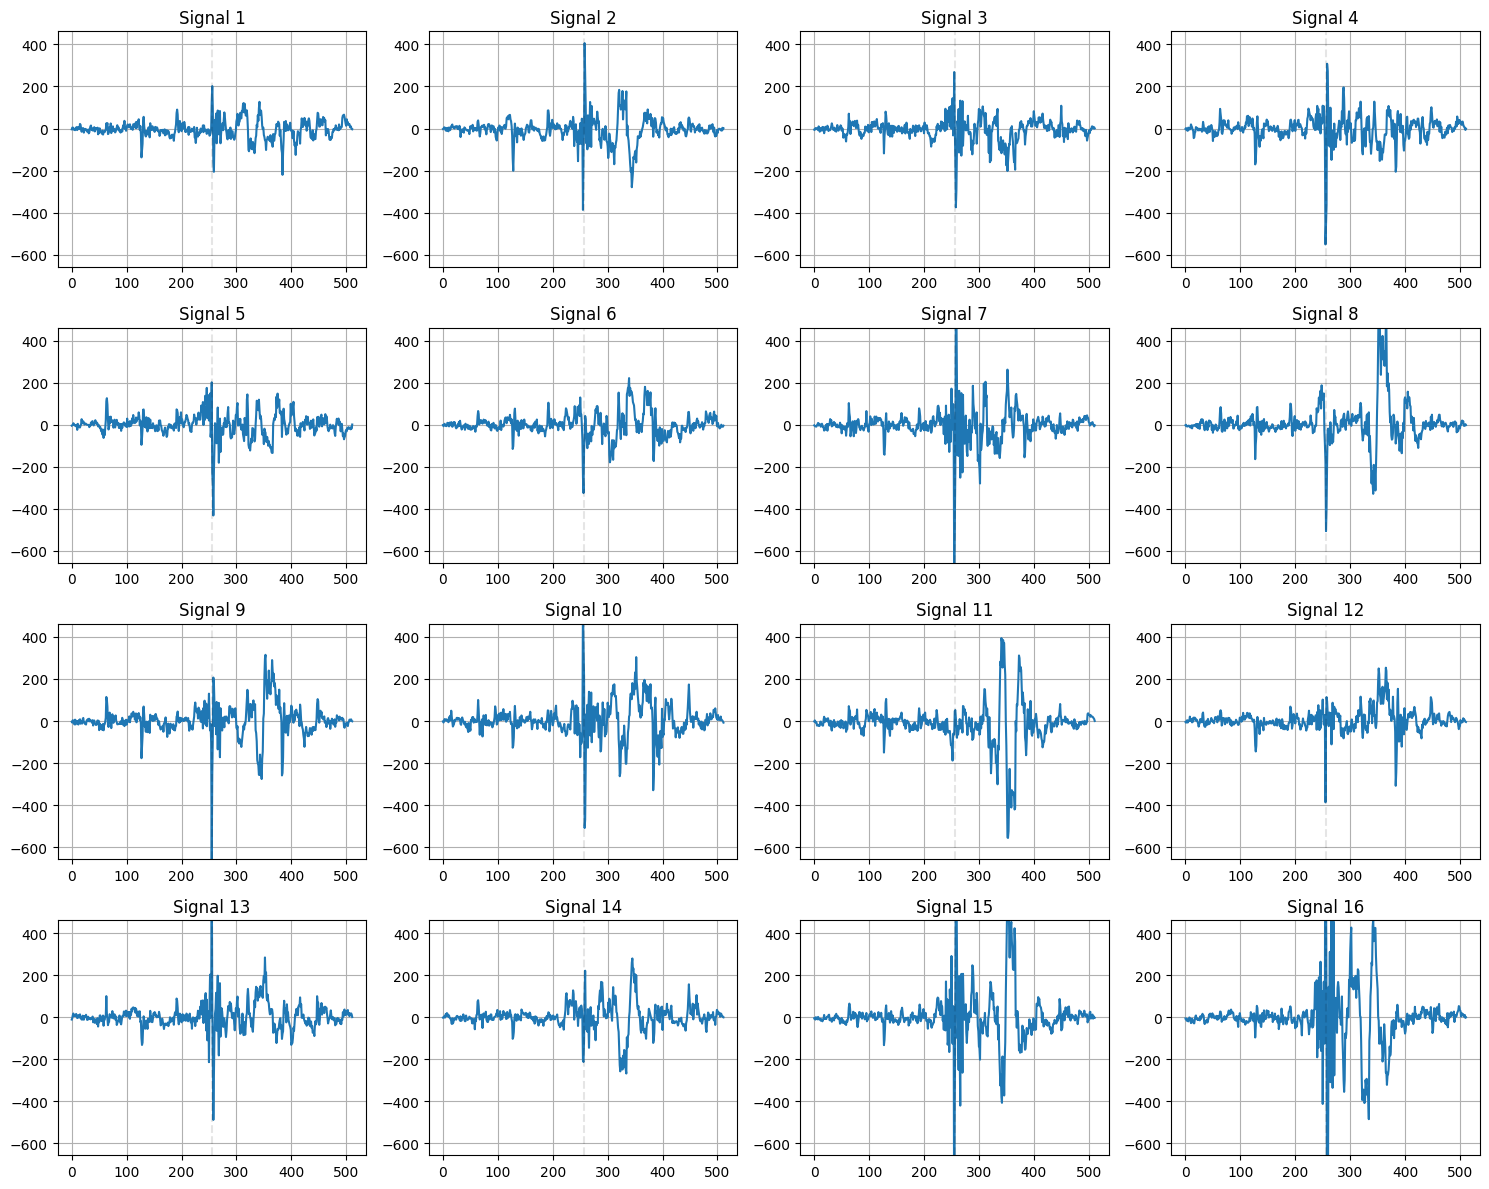

[4/20][0/188]	Loss_D: 0.7660	Loss_G: 2.0059	D(x): 0.1424	D(G(z)): 0.7887 / 0.7326
[4/20][50/188]	Loss_D: 0.8214	Loss_G: 2.6280	D(x): 0.0840	D(G(z)): 0.6225 / 0.7877
[4/20][100/188]	Loss_D: 0.7828	Loss_G: 2.1359	D(x): 0.1280	D(G(z)): 0.8040 / 0.7135
[4/20][150/188]	Loss_D: 0.9548	Loss_G: 2.3751	D(x): 0.1122	D(G(z)): 0.5986 / 0.7704
Epoch 4: SGD Discriminator lr 0.0000187 -> 0.0000183
Epoch 4: SGD Generator lr 0.0000373 -> 0.0000367


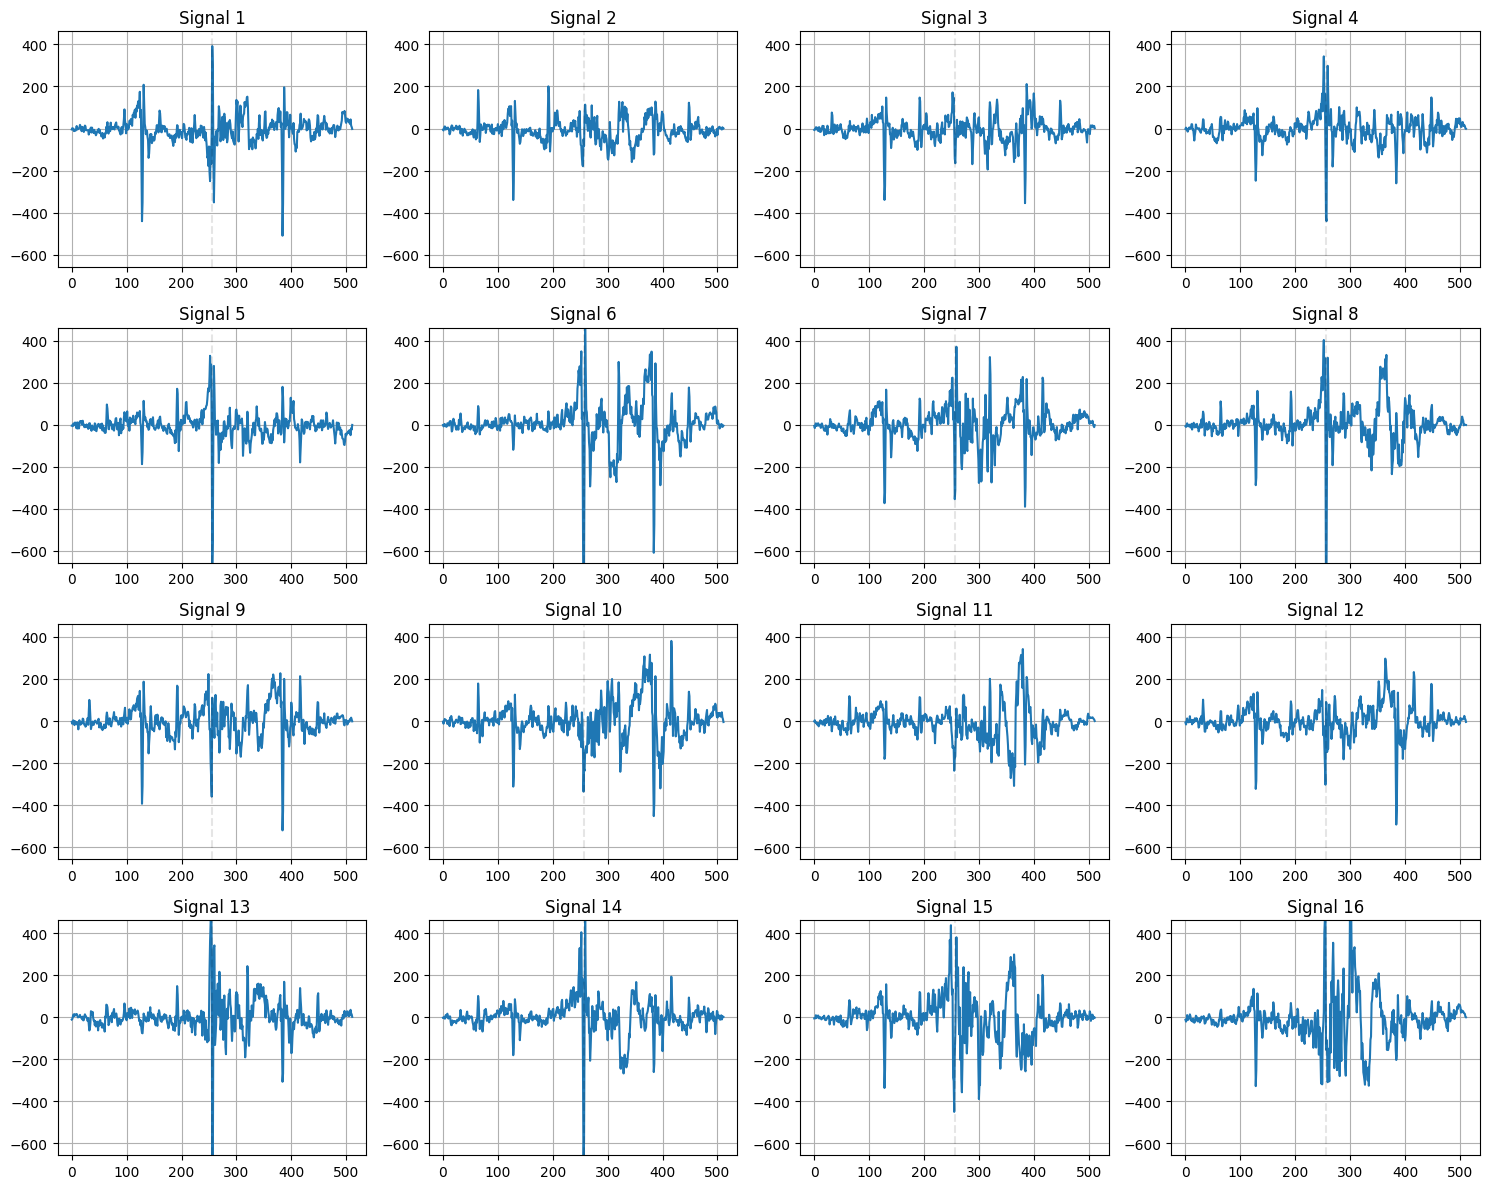

[5/20][0/188]	Loss_D: 0.7718	Loss_G: 2.6013	D(x): 0.1679	D(G(z)): 0.7360 / 0.7907
[5/20][50/188]	Loss_D: 0.8787	Loss_G: 3.2097	D(x): 0.1523	D(G(z)): 0.8017 / 0.8509
[5/20][100/188]	Loss_D: 0.7726	Loss_G: 2.6609	D(x): 0.0757	D(G(z)): 0.7451 / 0.7691
[5/20][150/188]	Loss_D: 0.7625	Loss_G: 3.4341	D(x): 0.1490	D(G(z)): 0.8153 / 0.8728
Epoch 5: SGD Discriminator lr 0.0000183 -> 0.0000180
Epoch 5: SGD Generator lr 0.0000367 -> 0.0000360


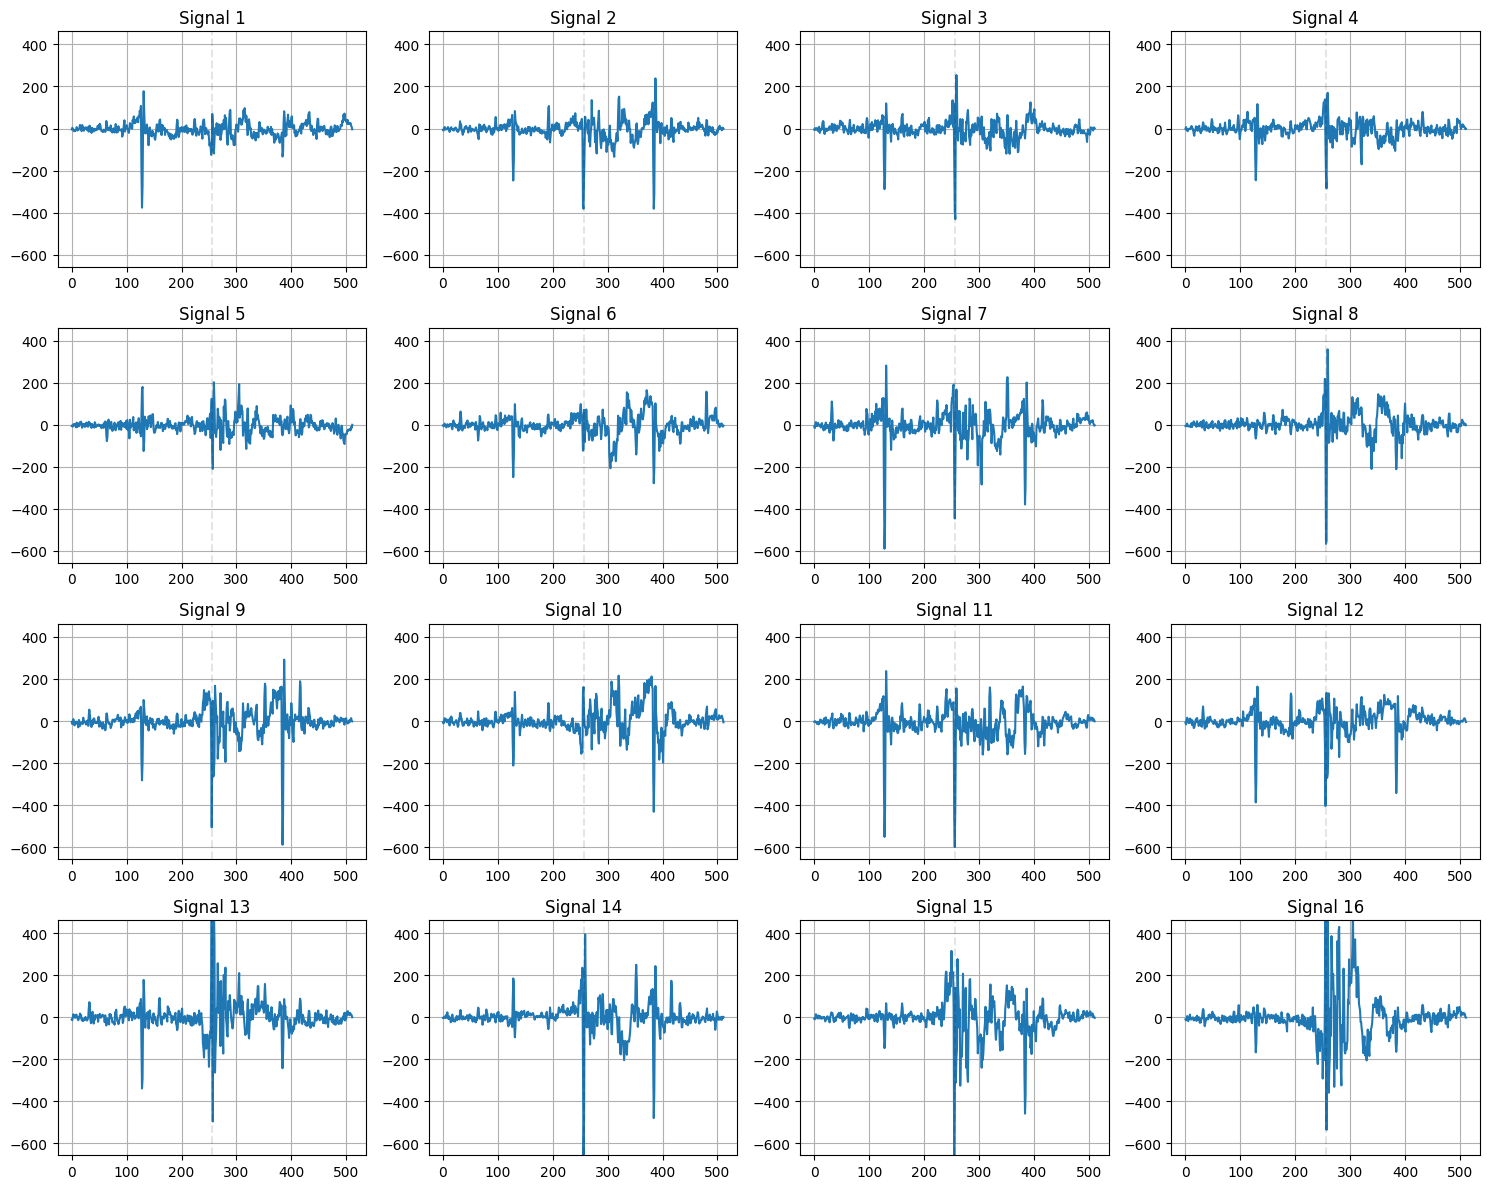

[6/20][0/188]	Loss_D: 0.7880	Loss_G: 2.5070	D(x): 0.1422	D(G(z)): 0.7318 / 0.7848
[6/20][50/188]	Loss_D: 0.7913	Loss_G: 3.2182	D(x): 0.1084	D(G(z)): 0.8381 / 0.8549
[6/20][100/188]	Loss_D: 0.7773	Loss_G: 2.5970	D(x): 0.1695	D(G(z)): 0.7396 / 0.7984
[6/20][150/188]	Loss_D: 0.7706	Loss_G: 2.6474	D(x): 0.1697	D(G(z)): 0.8217 / 0.8681
Epoch 6: SGD Discriminator lr 0.0000180 -> 0.0000177
Epoch 6: SGD Generator lr 0.0000360 -> 0.0000353


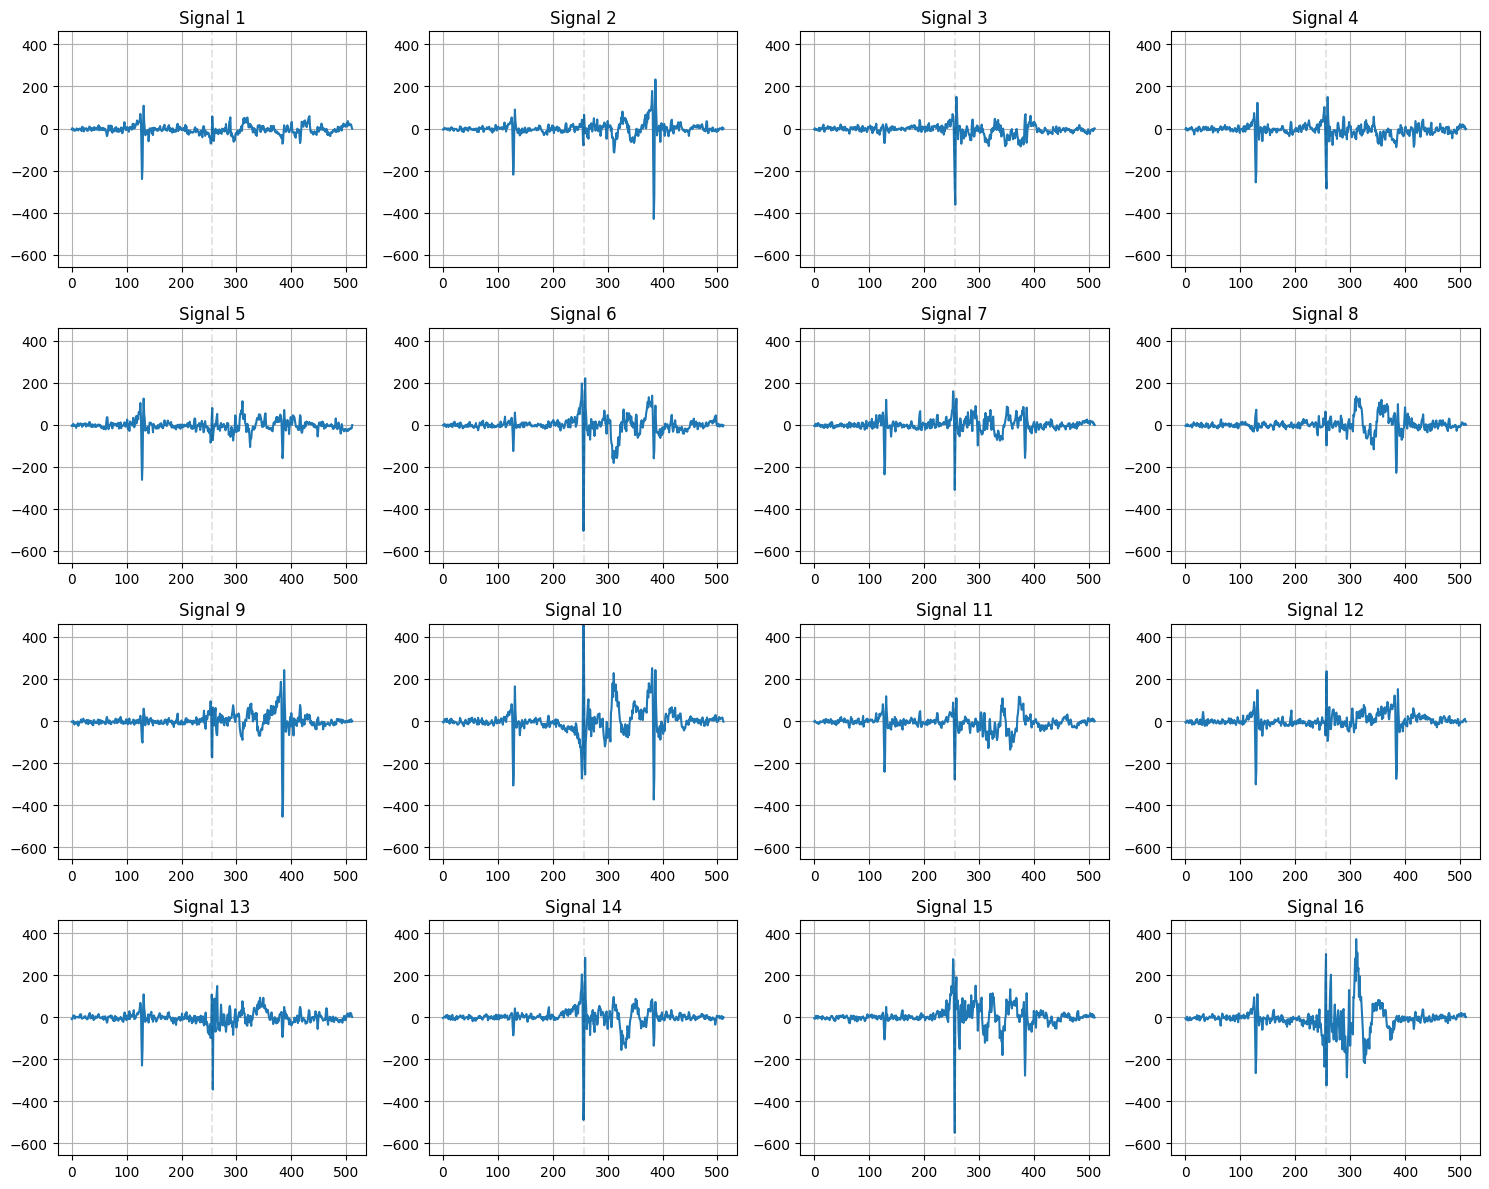

[7/20][0/188]	Loss_D: 0.6765	Loss_G: 3.0731	D(x): 0.0869	D(G(z)): 0.7311 / 0.8671
[7/20][50/188]	Loss_D: 0.7729	Loss_G: 2.4452	D(x): 0.1456	D(G(z)): 0.7535 / 0.7989
[7/20][100/188]	Loss_D: 0.6421	Loss_G: 3.0226	D(x): 0.0812	D(G(z)): 0.8370 / 0.8876
[7/20][150/188]	Loss_D: 0.7821	Loss_G: 1.5671	D(x): 0.1150	D(G(z)): 0.6804 / 0.6847
Epoch 7: SGD Discriminator lr 0.0000177 -> 0.0000173
Epoch 7: SGD Generator lr 0.0000353 -> 0.0000347


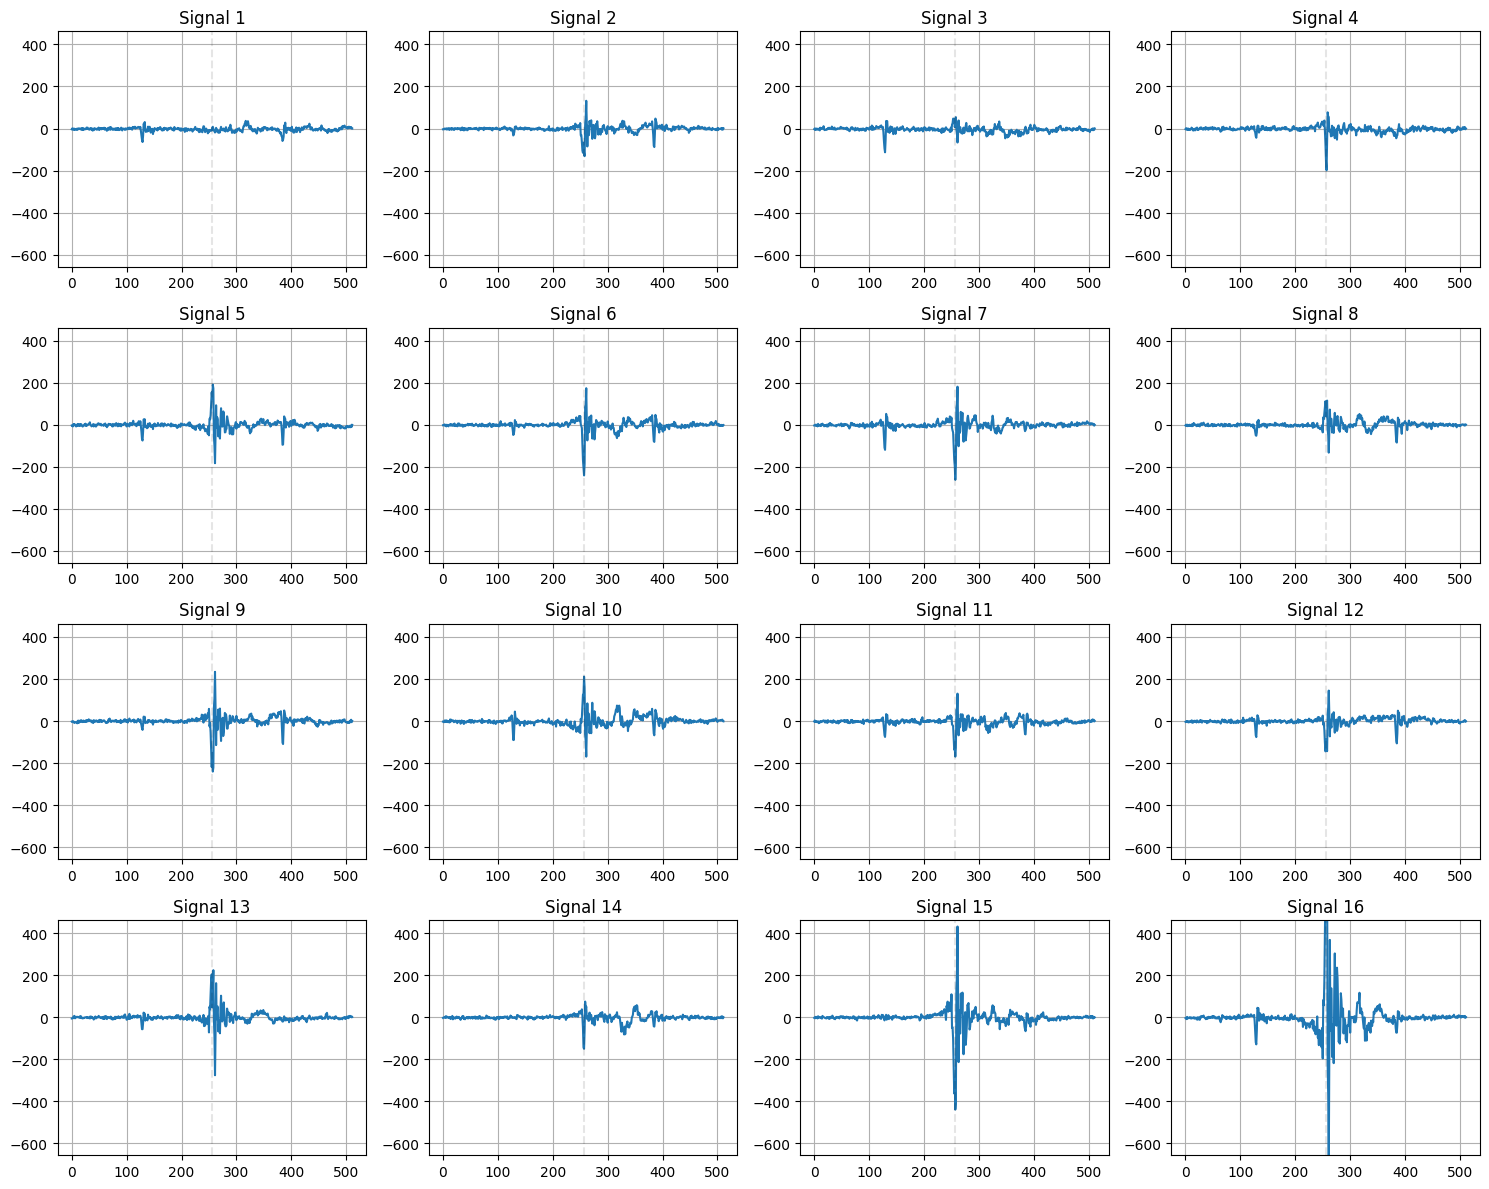

[8/20][0/188]	Loss_D: 0.8576	Loss_G: 3.3701	D(x): 0.1639	D(G(z)): 0.8583 / 0.8690
[8/20][50/188]	Loss_D: 0.6004	Loss_G: 1.7808	D(x): 0.0684	D(G(z)): 0.7439 / 0.7460
[8/20][100/188]	Loss_D: 0.7450	Loss_G: 2.4491	D(x): 0.1589	D(G(z)): 0.8223 / 0.7892
[8/20][150/188]	Loss_D: 0.5990	Loss_G: 2.4922	D(x): 0.1224	D(G(z)): 0.9056 / 0.8234
Epoch 8: SGD Discriminator lr 0.0000173 -> 0.0000170
Epoch 8: SGD Generator lr 0.0000347 -> 0.0000340


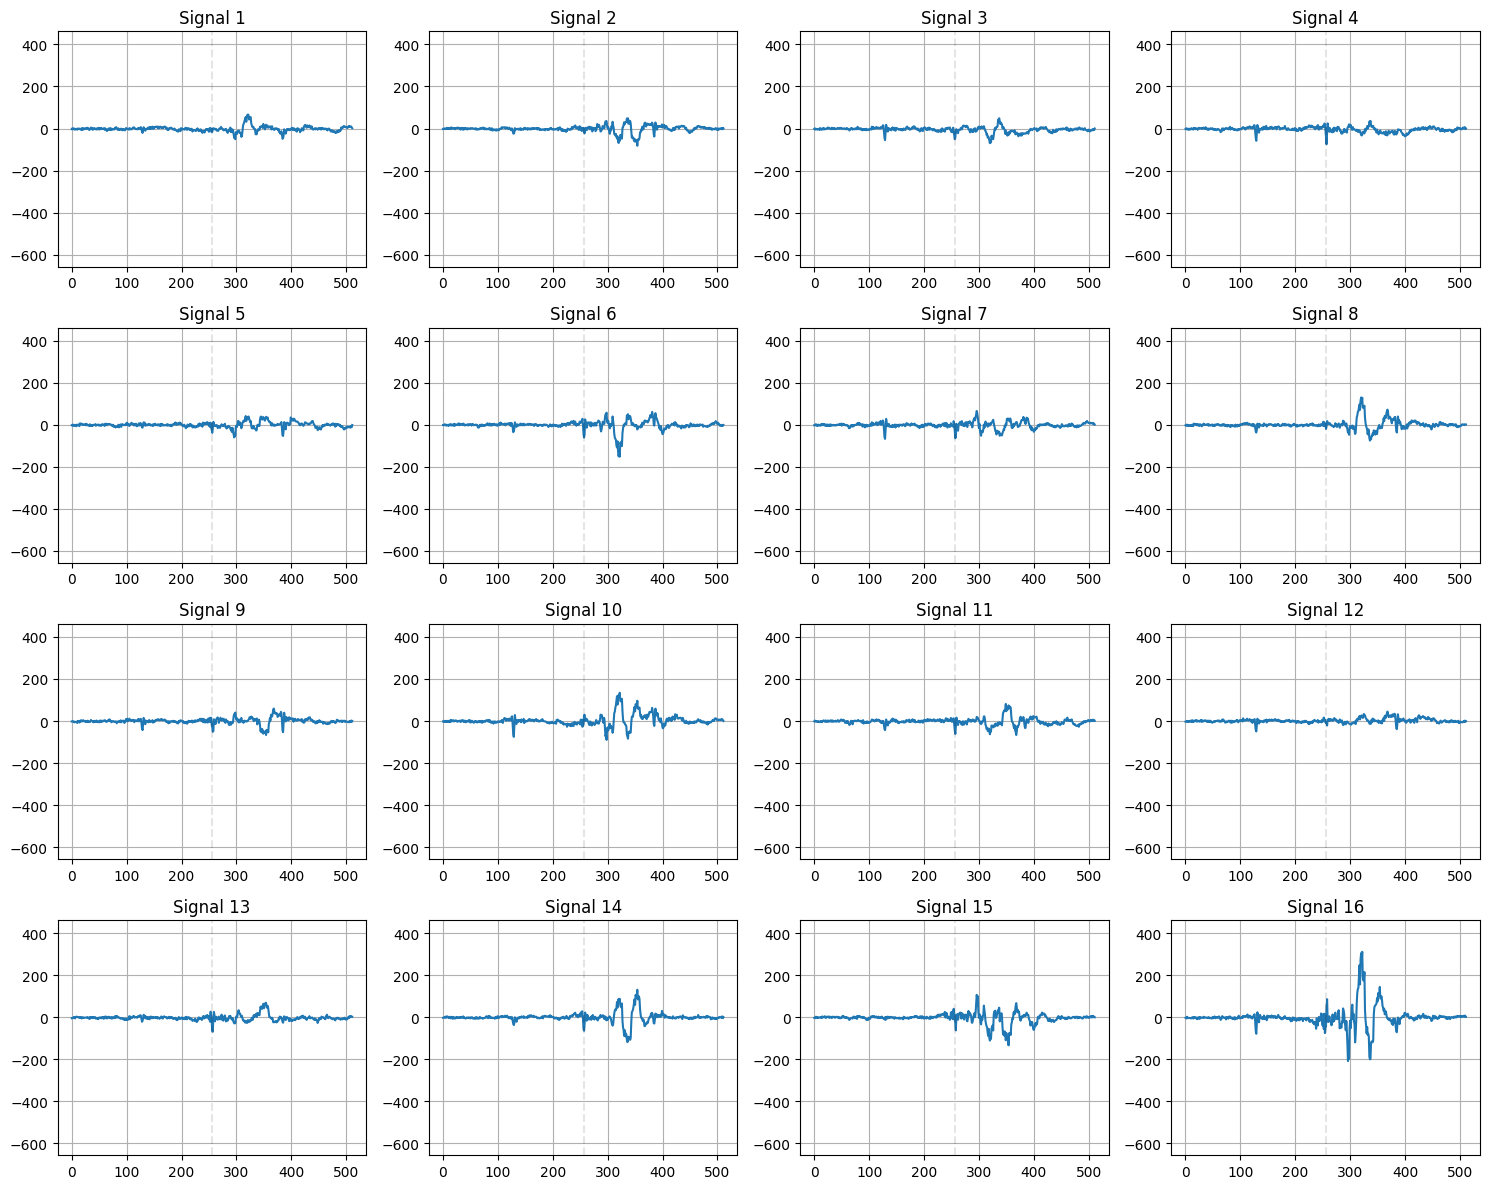

[9/20][0/188]	Loss_D: 0.5331	Loss_G: 2.0930	D(x): 0.0499	D(G(z)): 0.7610 / 0.7640
[9/20][50/188]	Loss_D: 0.7409	Loss_G: 2.6714	D(x): 0.1600	D(G(z)): 0.7202 / 0.8285
[9/20][100/188]	Loss_D: 0.6065	Loss_G: 1.7901	D(x): 0.0659	D(G(z)): 0.7474 / 0.7235
[9/20][150/188]	Loss_D: 0.7229	Loss_G: 2.4365	D(x): 0.1280	D(G(z)): 0.8252 / 0.7921
Epoch 9: SGD Discriminator lr 0.0000170 -> 0.0000167
Epoch 9: SGD Generator lr 0.0000340 -> 0.0000333


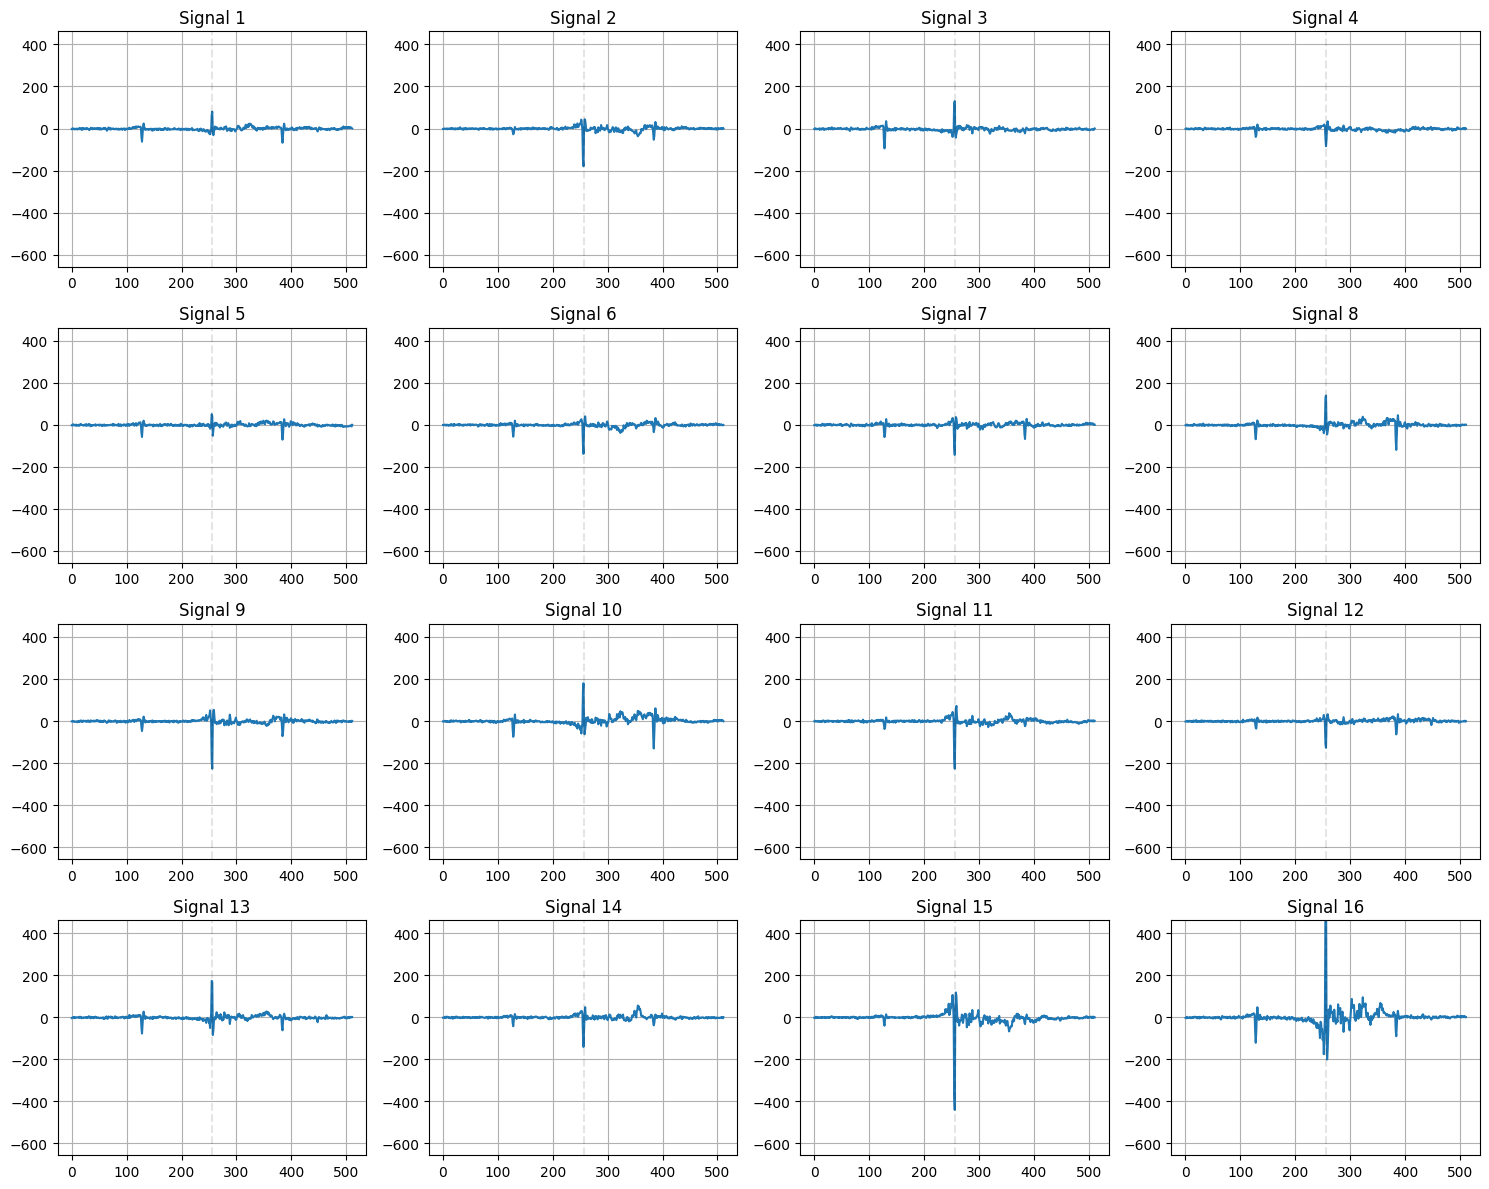

[10/20][0/188]	Loss_D: 0.5891	Loss_G: 2.7401	D(x): 0.0954	D(G(z)): 0.8548 / 0.8270
[10/20][50/188]	Loss_D: 0.6876	Loss_G: 2.0137	D(x): 0.1435	D(G(z)): 0.7924 / 0.7376
[10/20][100/188]	Loss_D: 0.6219	Loss_G: 2.0726	D(x): 0.0484	D(G(z)): 0.8189 / 0.7339
[10/20][150/188]	Loss_D: 0.7213	Loss_G: 2.9822	D(x): 0.1265	D(G(z)): 0.7462 / 0.8353
Epoch 10: SGD Discriminator lr 0.0000167 -> 0.0000163
Epoch 10: SGD Generator lr 0.0000333 -> 0.0000327


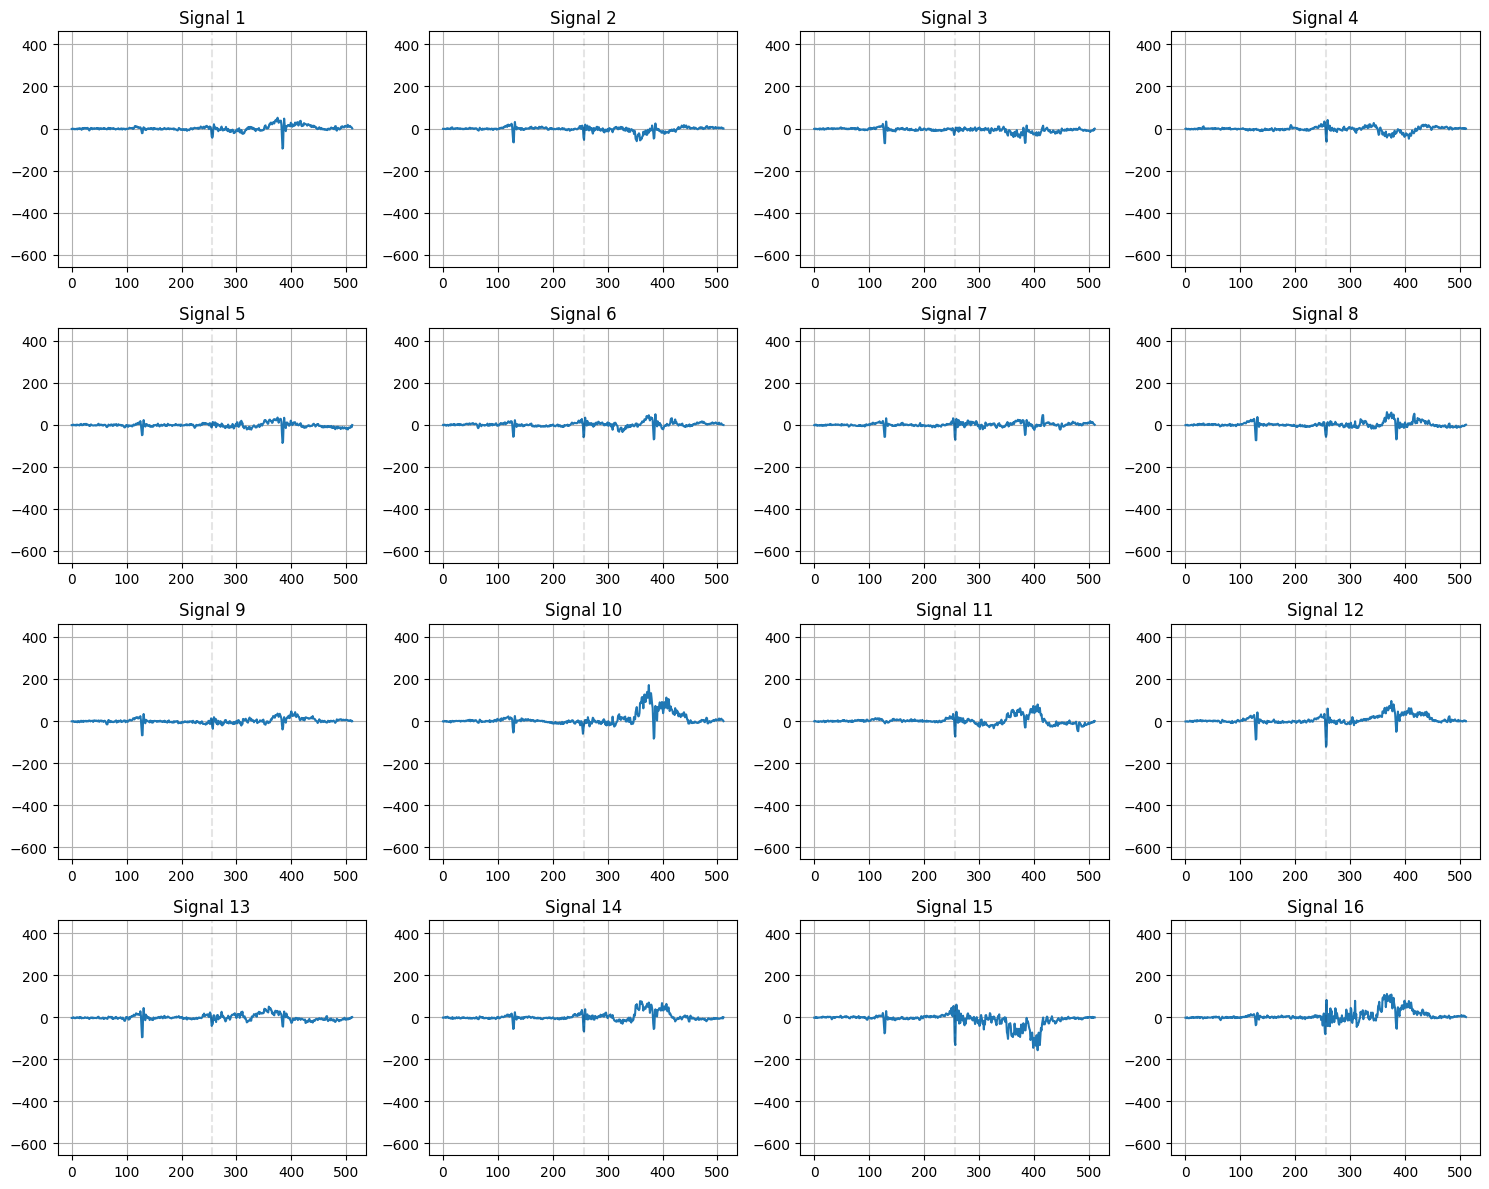

[11/20][0/188]	Loss_D: 0.8700	Loss_G: 2.5625	D(x): 0.1617	D(G(z)): 0.7124 / 0.8062
[11/20][50/188]	Loss_D: 0.7001	Loss_G: 2.2707	D(x): 0.0970	D(G(z)): 0.7945 / 0.7724
[11/20][100/188]	Loss_D: 0.6912	Loss_G: 1.9983	D(x): 0.1151	D(G(z)): 0.7797 / 0.7572
[11/20][150/188]	Loss_D: 0.6744	Loss_G: 2.0127	D(x): 0.1098	D(G(z)): 0.7861 / 0.7577
Epoch 11: SGD Discriminator lr 0.0000163 -> 0.0000160
Epoch 11: SGD Generator lr 0.0000327 -> 0.0000320


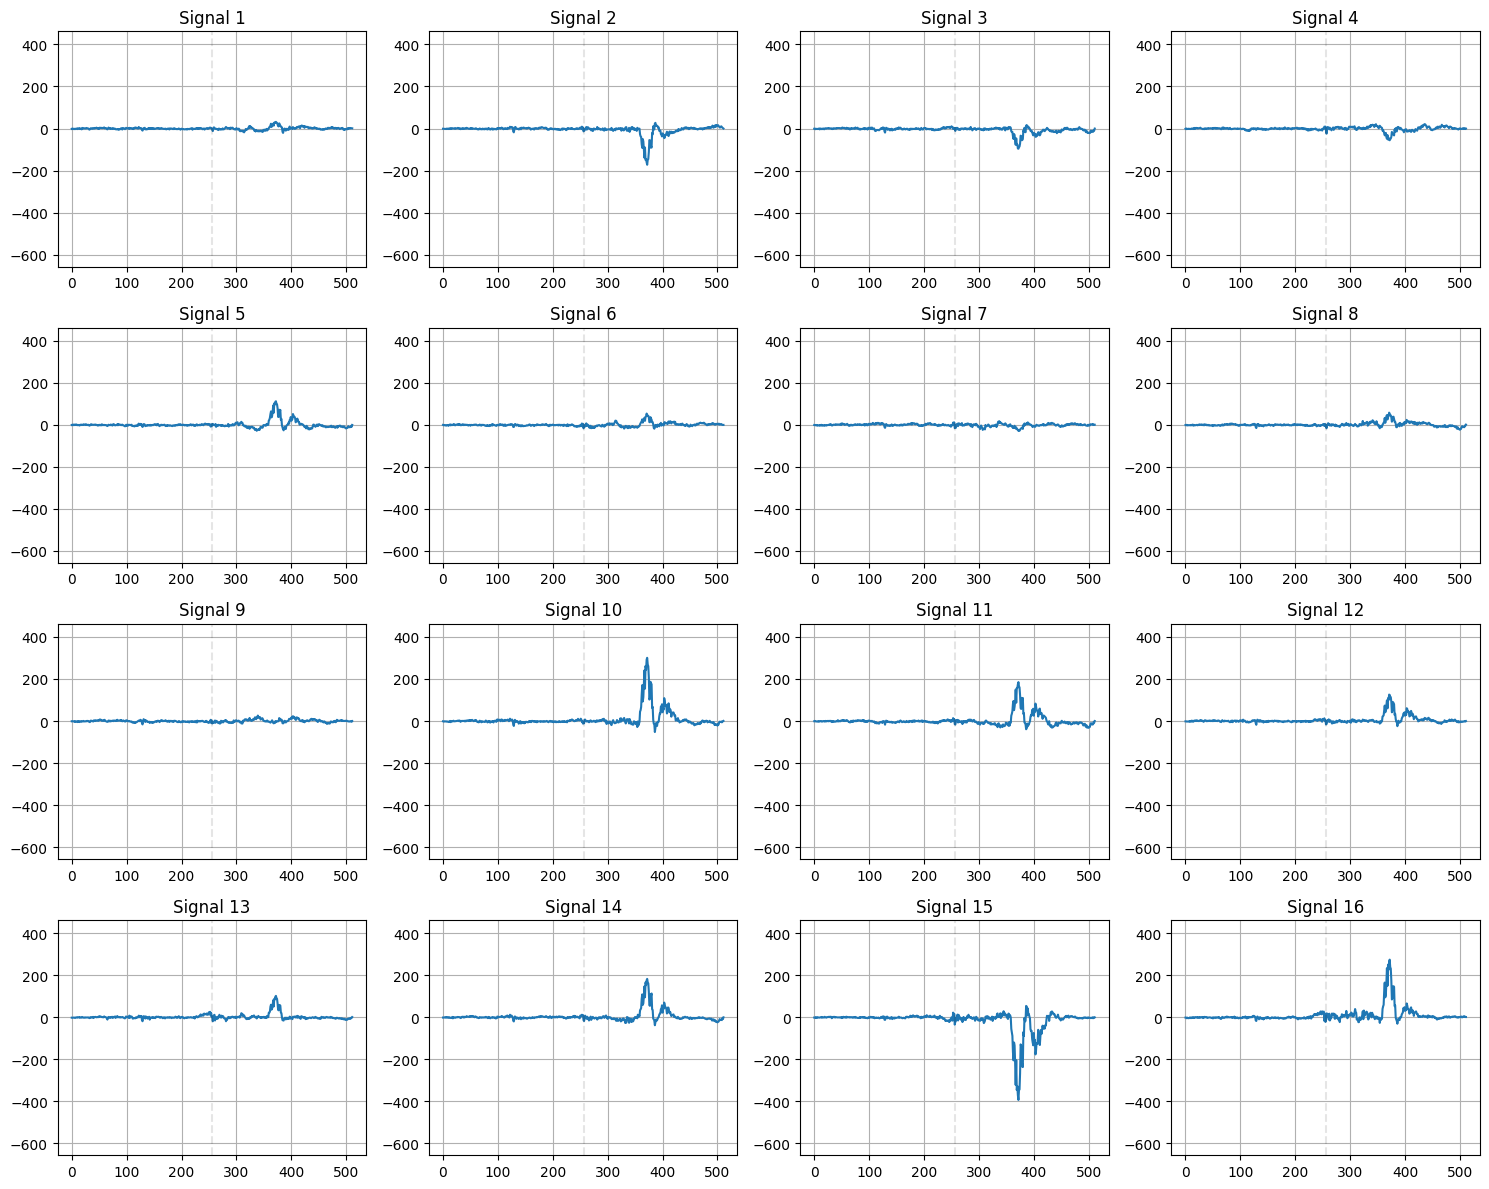

[12/20][0/188]	Loss_D: 0.8983	Loss_G: 2.9460	D(x): 0.1416	D(G(z)): 0.7225 / 0.8768
[12/20][50/188]	Loss_D: 0.7420	Loss_G: 2.9821	D(x): 0.0633	D(G(z)): 0.8270 / 0.8279
[12/20][100/188]	Loss_D: 0.6312	Loss_G: 2.3790	D(x): 0.0951	D(G(z)): 0.8534 / 0.7733
[12/20][150/188]	Loss_D: 0.6463	Loss_G: 2.6837	D(x): 0.1414	D(G(z)): 0.8270 / 0.8467
Epoch 12: SGD Discriminator lr 0.0000160 -> 0.0000157
Epoch 12: SGD Generator lr 0.0000320 -> 0.0000313


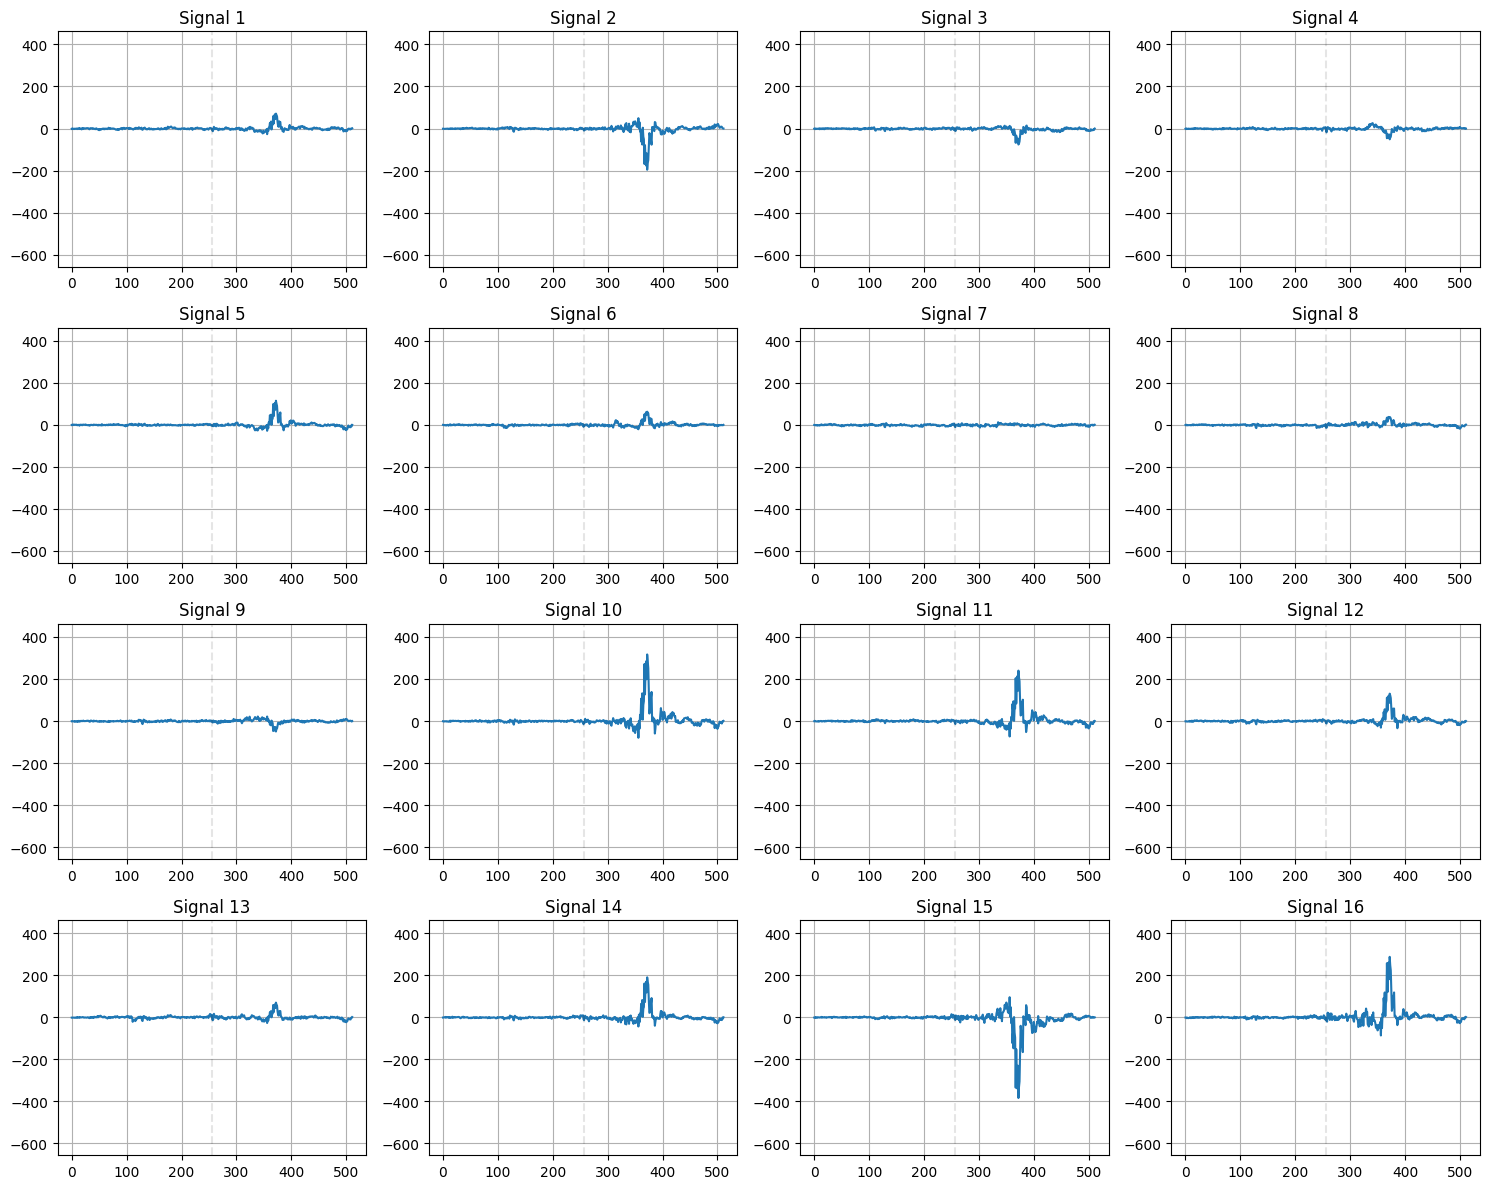

[13/20][0/188]	Loss_D: 0.6778	Loss_G: 1.5899	D(x): 0.1100	D(G(z)): 0.8476 / 0.6757


KeyboardInterrupt: 

In [38]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data[0].to(device)
        real_parameters_gpu = data[1].to(device)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # soft labelling
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        # flip selected labels
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1) # add parameters here!!!
        # output = netD(real_gpu, real_parameters_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device) # do we increase nz by 3 for parameters?
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    # learning-rate decay
    before_lr = optimizerD.param_groups[0]["lr"]
    schedulerD.step()
    after_lr = optimizerD.param_groups[0]["lr"]
    print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

    before_lr = optimizerG.param_groups[0]["lr"]
    schedulerG.step()
    after_lr = optimizerG.param_groups[0]["lr"]
    print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

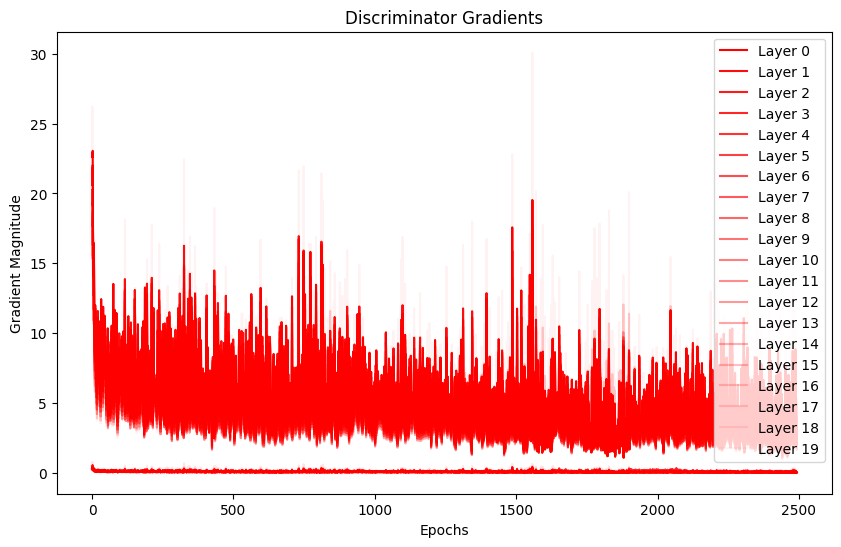

In [39]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

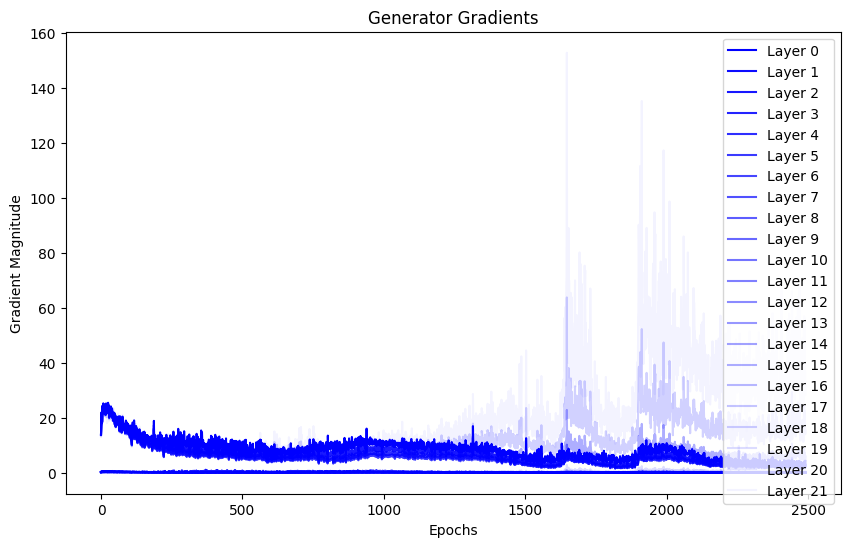

In [40]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

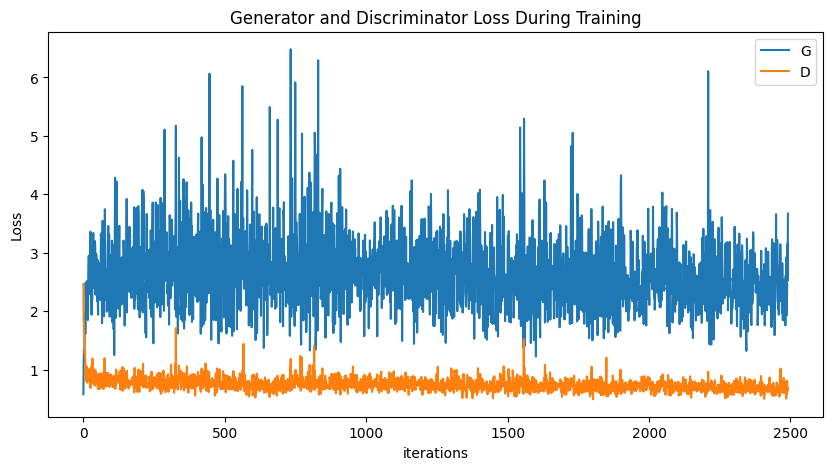

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


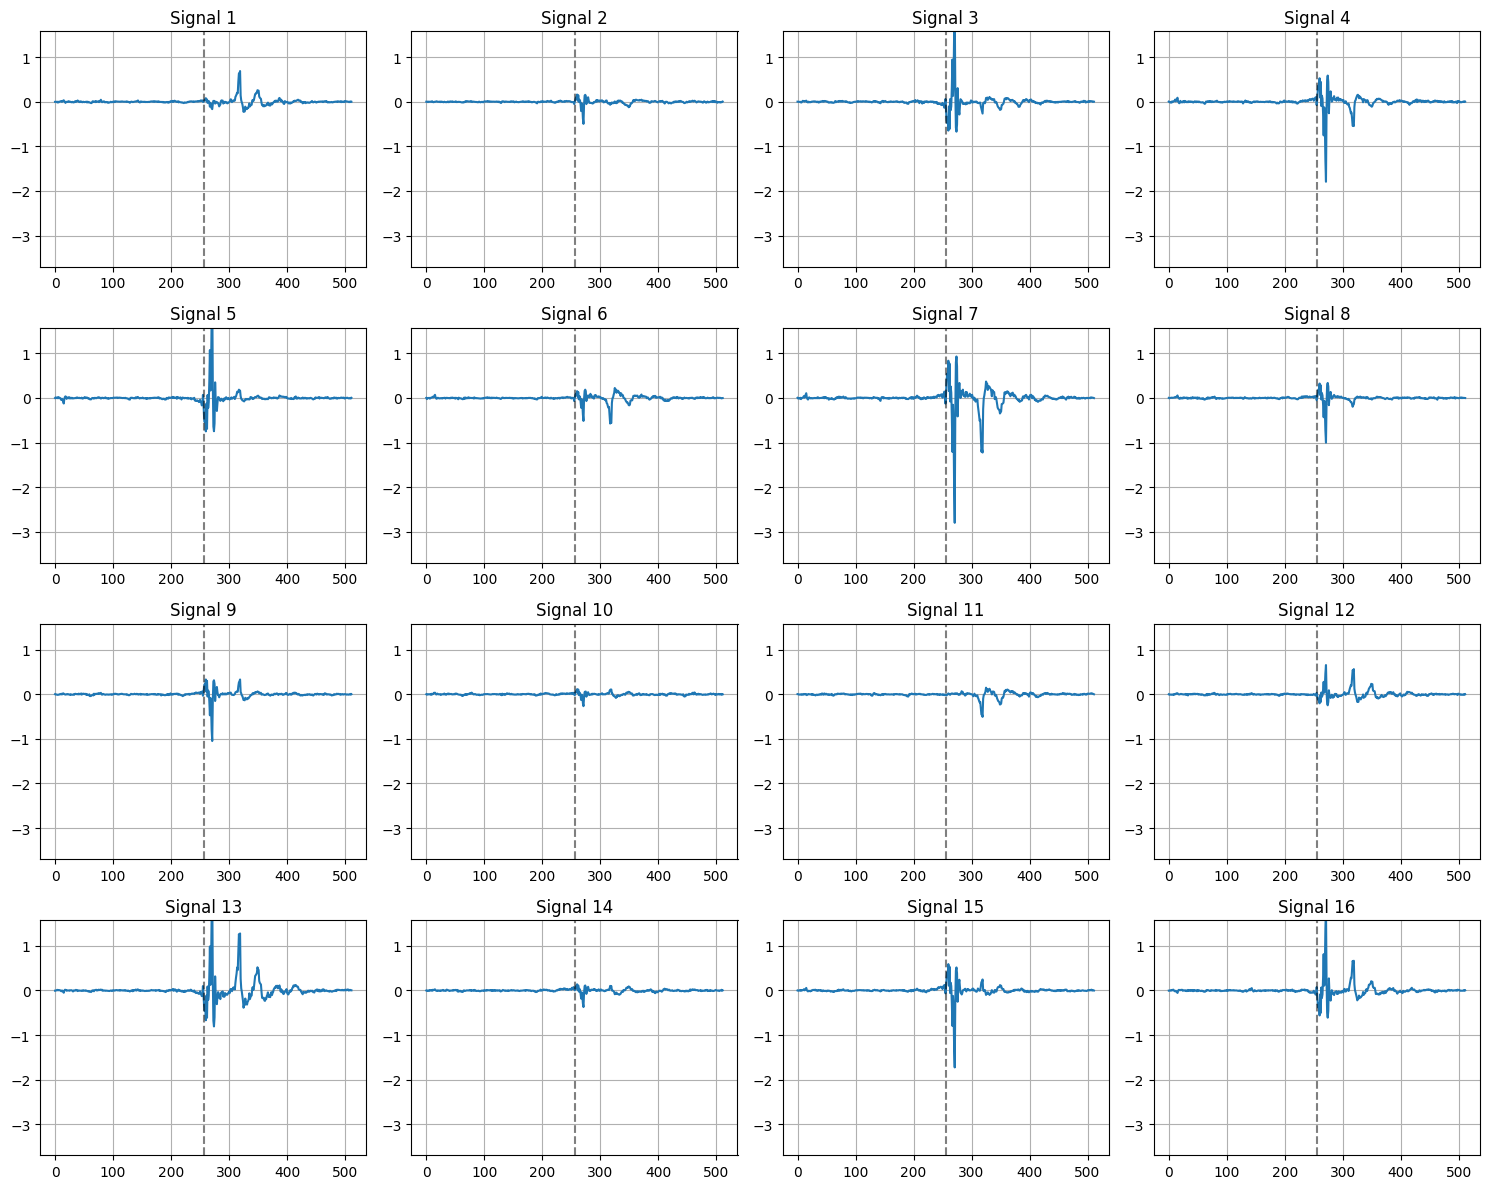

In [ ]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [ ]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)


### Evaluation Metrics for GANS